In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# my add
import quaternion
from src.support_class import *
import importlib
from codeStore import support_fun_table as spf_tb
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

%load_ext autoreload
%autoreload 2

In [2]:
class Quaternion(object):
    """docstring for Quaternion"""
    def __init__(self, axis = None, angle = 0):
        super(Quaternion, self).__init__()

        if axis is None:
            axis = np.array([0,0,1.0])
        axis = np.array(axis)

        xyz= np.sin(.5*angle)*axis/np.linalg.norm(axis)
        self.q = np.array([
                np.cos(.5*angle),
                xyz[0],
                xyz[1],
                xyz[2]
            ])


    def __add__(self, other):
        Q = Quaternion()
        Q.q = self.q + other
        return Q

    def mul(self, other):
        assert(type(other) is Quaternion)

        W = self.q[0]
        X = self.q[1]
        Y = self.q[2]
        Z = self.q[3]

        w = other.q[0]
        x = other.q[1]
        y = other.q[2]
        z = other.q[3]

        Q = Quaternion()
        Q.q = np.array([
                w * W - x * X - y * Y - z * Z,
                W * x + w * X + Y * z - y * Z,
                W * y + w * Y - X * z + x * Z,
                X * y - x * Y + W * z + w * Z
            ])
        return Q
    
    def set_wxyz(self, w, x, y, z):
        self.q = np.array([w, x, y, z])
        
    def __str__(self):
        return str(self.q)

    def normalize(self):
        self.q = self.q / np.linalg.norm(self.q)

    def get_E(self):
        W = self.q[0]
        X = self.q[1]
        Y = self.q[2]
        Z = self.q[3]

        return np.array([
            [-X, W, -Z, Y],
            [-Y, Z, W, -X],
            [-Z, -Y, X, W]
            ])

    def get_G(self):
        W = self.q[0]
        X = self.q[1]
        Y = self.q[2]
        Z = self.q[3]

        return np.array([
            [-X, W, Z, -Y],
            [-Y, -Z, W, X],
            [-Z, Y, -X, W]
            ])

    def get_R(self):
        return np.matmul(self.get_E(), self.get_G().T)

# Functions for angular velocity & integration

The particle is an ellipsoid. The reference state (corresponding to no rotation) is that the ellipsoid is axis-aligned and the axis lengths are (a_x, a_y, a_z). The shape parameters in the code below are

```
l = a_z/a_x
k = a_y/a_x
```

Its orientation is represented by the rotation (as a Quaternion) from the reference state. See Appendix A of https://arxiv.org/abs/1705.06997 for the quaternion convention.

In [3]:
def jeffery_omega(L, K, n1, n2, n3, Omega, E):
    """
    Compute Jeffery angular velocity
    
    L: (lambda^2-1)/(lambda^2+1)
    K: (kappa^2-1)/(kappa^2+1)
    n1,n2,n3: vector triplet representing current orientation
    Omega: vorticity (lab frame) 
    E: strain matrix (lab frame)

    Returns (3,) ndarray with angular velocity of particle (body frame)
    See Appendix A in http://hdl.handle.net/2077/40830
    """

    omega1 = n1.dot(Omega) + (L-K)/(L*K-1.) * (n2.dot(E.dot(n3)))
    omega2 = n2.dot(Omega) + L * (n1.dot(E.dot(n3)))
    omega3 = n3.dot(Omega) - K * (n1.dot(E.dot(n2)))

    return np.array([omega1, omega2, omega3])


def jeffery_numerical(L, K, q0, Omega, E, max_t = None, dt = 1e-3, return_n1s=False):
    """
    Integrate one trajectory according to Jeffery's equations.
    
    L: (lambda^2-1)/(lambda^2+1) shape parameter 1
    K: (kappa^2-1)/(kappa^2+1) shape parameter 2  
    q0: quaternion representing initial orientation
    Omega: vorticity (lab frame) 
    E: strain matrix (lab frame)
    max_t: Max time of trajectory, defaults to 2 Jeffery periods based on L
    dt: Integration timestep
    
    See Appendix A in https://arxiv.org/abs/1705.06997 for quaternion convention.
    
    Returns (ts, qs, n2s, n3s) where
        ts is (N,1) ndarray with timestamps (starting at 0) for N steps
        qs is (N,4) ndarray with orientations (quaternions) for N steps
        n2s is (N,3) ndarray with n2 vector for N steps
        n3s is (N,3) ndarray with n3 vector for N steps        
    """
    
    if max_t is None:
        maxKL = max(abs(L),abs(K))
        jeffery_T = 4*np.pi/np.sqrt(1-maxKL*maxKL)
        max_t = 2*jeffery_T
    
    N = int(max_t/dt)

    ts = np.zeros((N,1))
    n1s = np.zeros((N,3))
    n2s = np.zeros((N,3))
    n3s = np.zeros((N,3))    
    qs = np.zeros((N,4))
    q = q0
    t=0
    for n in range(N):
        R = q.get_R()
        n1 = R[:,0]
        n2 = R[:,1]
        n3 = R[:,2]        
        
        ts[n] = n*dt
        n1s[n,:] = n1
        n2s[n,:] = n2
        n3s[n,:] = n3
        qs[n,:] = q.q
        
        omega = jeffery_omega(L, K, n1, n2, n3, Omega, E)
        qdot = 0.5 * omega.dot(q.get_G())
#         # dbg
#         qdot1 = Quaternion()
#         qdot1.set_wxyz(*qdot)
#         print(omega)
#         print(qdot1)
#         print(qdot1.get_R())
#         print()
        q = q + dt*qdot
        q.normalize()
    
    if return_n1s:
        return ts, qs, n1s, n2s, n3s
    else:
        return ts, qs, n2s, n3s

def jeffery_axisymmetric_exact(L, q0, Omega, E, max_t = None, dt = 1e-1):
    """
    Generate one exact trajectory for axisymmetric particle ('Jeffery orbit')
    
    L: (lambda^2-1)/(lambda^2+1) shape parameter
    q0: quaternion representing initial orientation
    Omega: vorticity (lab frame) 
    E: strain matrix (lab frame)
    max_t: Max time of trajectory, defaults to 2 Jeffery periods based on L
    dt: Sample spacing
    
    See Appendix A in https://arxiv.org/abs/1705.06997 for quaternion convention.
    
    Returns (ts, qs, n2s, n3s) where
        ts is (N,1) ndarray with timestamps (starting at 0) for N steps
        n3s is (N,3) ndarray with n3 vector for N steps        
    """    
    if max_t is None:
        jeffery_T = 4*np.pi/np.sqrt(1-L*L)
        max_t = 2*jeffery_T

    N = int(max_t/dt)    
        
    levi_civita = np.zeros((3, 3, 3))
    levi_civita[0, 1, 2] = levi_civita[1, 2, 0] = levi_civita[2, 0, 1] = 1
    levi_civita[0, 2, 1] = levi_civita[2, 1, 0] = levi_civita[1, 0, 2] = -1        
    O = -np.einsum('ijk,k',levi_civita, Omega)
 
    B = O + L*E
    n30 = q0.get_R().dot(np.array([0,0,1]))
    
    ts = np.zeros((N,1))
    n3s = np.zeros( (N,3) )
    for n in range(N):

        t = dt*n

        M = scipy.linalg.expm(B*t)
        n3 = M.dot(n30)
        n3 = n3/np.linalg.norm(n3)

        ts[n] = t
        n3s[n,:] = n3
    
    return (ts, n3s)

# Omega & E (strain) for simple shear flow

In [4]:
Omega = np.array([0,0,-.5])
E = np.array([
    [0,.5,0],
    [.5,0,0],
    [0,0,0]
])

# Validate code against axisymmetric case (Jeffery orbits)

In [153]:
t1 = np.array((0, 1, 0))
t2 = np.array((0, 0, -1))
print(np.cross(t1, t2))

[-1  0  0]


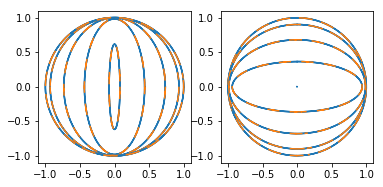

In [5]:
angles = np.pi/2 * np.linspace(0.05,1,5)

## first test is axisymmetric along n3 (K=0)
ax = plt.subplot(1,2,1)
for angle in angles:
    q0 = Quaternion(axis=[0,1,0], angle=angle)

    l = 0.1
    k = 1
    L = (l**2-1)/(l**2+1)
    K = (k**2-1)/(k**2+1)

    (ts, qs, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E)
    ax.plot(n3s[:,0],n3s[:,1],ls='solid', color='C0')

    (ts, n3s) = jeffery_axisymmetric_exact(L,q0,Omega,E)
    ax.plot(n3s[:,0],n3s[:,1],ls=(0, (5, 10)),color='C1')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')    

## second test is axisymmetric along n2 (L=0)
ax = plt.subplot(1,2,2)
for angle in angles:
    q0_tri = Quaternion(axis=[1,0,0], angle=-angle)
    q0_axi = Quaternion(axis=[1,0,0], angle=np.pi/2-angle)
    l = 1
    k = 7
    L = (l**2-1)/(l**2+1)
    K = (k**2-1)/(k**2+1)

    (ts, qs, n2s, n3s) = jeffery_numerical(L, K, q0_tri, Omega, E)
    ax.plot(n2s[:,0],n2s[:,1],ls='solid', color='C0')

    (ts, n3s) = jeffery_axisymmetric_exact(K,q0_axi,Omega,E)
    ax.plot(n3s[:,0],n3s[:,1],ls=(0, (5, 10)),color='C1')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')    

plt.show()
    

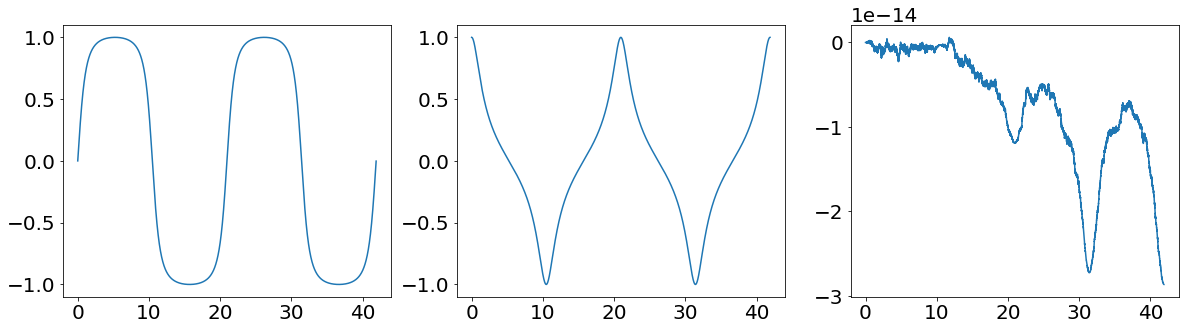

In [160]:
angle = np.random.sample(1)[0]
q0 = Quaternion(axis=[0,1,0], angle=angle)
l = 1
k = 3
L = (l**2-1)/(l**2+1)
K = (k**2-1)/(k**2+1)

(ts, qs, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axs[0].plot(ts, n2s[:, 0])
axs[1].plot(ts, n2s[:, 1])
axs[2].plot(ts, n2s[:, 2])


[ 37  30 -51]
last norm:  1.541862251633837 , 0.18905008702601211 , 2.627936661217286
do_calculate_ecoli_Petsc: run 100 loops/times using 7.224449s
scipy_RK45 rt1e-09, at1e-12, dt1e-02 7.2s


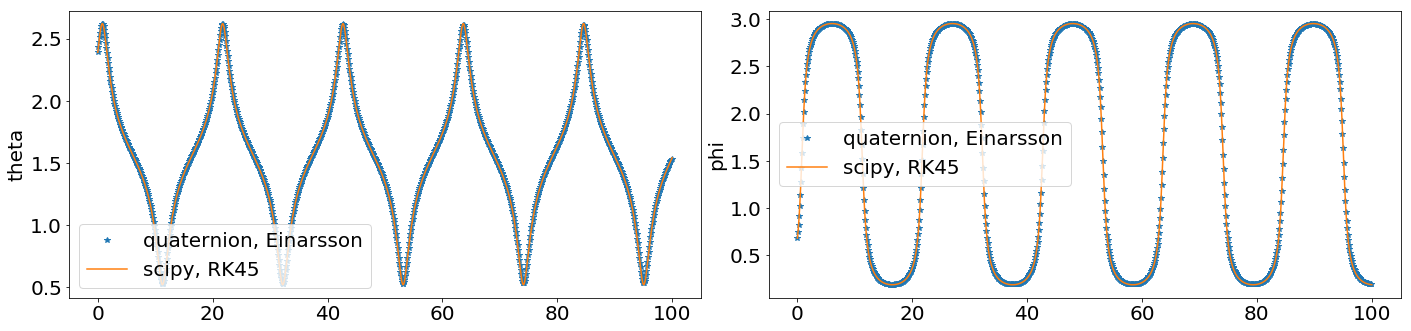

In [145]:
# dbg my code, compare with this code. 
max_t = 100
eval_dt = 1e-2
tnorm = np.random.randint(-100, 100, size=3)
print(tnorm)
norm = np.array((tnorm[0], tnorm[2], -tnorm[1]))
norm = norm / np.linalg.norm(norm)
tlateral_norm = np.random.sample(3)
tlateral_norm = tlateral_norm / np.linalg.norm(tlateral_norm)
tlateral_norm = tlateral_norm - norm * np.dot(norm, tlateral_norm)
tlateral_norm = tlateral_norm / np.linalg.norm(tlateral_norm)
P0 = norm / np.linalg.norm(norm)
P20 = tlateral_norm / np.linalg.norm(tlateral_norm) 
e = np.identity(3)
e0 = np.vstack((np.cross(P0, P20), P0, P20)).T
tR = rotMatrix_DCM(*e0, *e)
q0 = Quaternion()
q0.set_wxyz(*quaternion.as_float_array(quaternion.from_rotation_matrix(tR)))

l = 1
k = 3
L = (l**2-1)/(l**2+1)
K = (k**2-1)/(k**2+1)

(ts, qs, n1s, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E, dt=eval_dt, max_t=max_t, return_n1s=True)
t_theta_all = np.arccos(n2s[:, 1] / np.linalg.norm(n2s, axis=1))
t_phi_all = np.arctan2(-n2s[:, 2], n2s[:, 0])
t_phi_all = np.hstack([t1 + 2 * np.pi if t1 < 0 else t1 for t1 in t_phi_all])  # (-pi,pi) -> (0, 2pi)


# passive ellipse Rk method. 
importlib.reload(spf_tb)
t0 = time()
update_fun='RK45'
rtol=1e-9
atol=1e-12
save_every = 1

Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
   = spf_tb.do_calculate_ellipse_RK(tnorm, 0, max_t, update_fun=update_fun, 
                                     rtol=rtol, atol=atol)
t1 = time()
print('last norm: ', Table_theta[-1], ',', Table_phi[-1], ',', Table_psi[-1])
print('%s: run %d loops/times using %fs' % ('do_calculate_ecoli_Petsc', max_t, (t1 - t0)))
print('%s_%s rt%.0e, at%.0e, dt%.0e %.1fs' % ('scipy', update_fun, rtol, atol, eval_dt, (t1 - t0)))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for axi, ty, ylabel in zip(axs.flatten(), (t_theta_all, t_phi_all), ('theta', 'phi')):
    axi.plot(ts, ty, '*', label='quaternion, Einarsson', markevery=10)
for axi, ty, ylabel in zip(axs.flatten(), (Table_theta, Table_phi), ('theta', 'phi')):
    axi.plot(Table_t, ty, label='scipy, RK45')
    axi.set_ylabel(ylabel)
    axi.legend()
plt.tight_layout()


In [152]:
np.random.seed(0)
np.random.sample(3)

array([0.54881, 0.71519, 0.60276])

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.99999875e-01 -4.99999969e-04  0.00000000e+00]
 [ 9.99999500e-01 -9.99999813e-04  0.00000000e+00]
 [ 9.99998875e-01 -1.49999941e-03  0.00000000e+00]
 [ 9.99998000e-01 -1.99999863e-03  0.00000000e+00]
 [ 9.99996875e-01 -2.49999734e-03  0.00000000e+00]
 [ 9.99995500e-01 -2.99999544e-03  0.00000000e+00]
 [ 9.99993875e-01 -3.49999278e-03  0.00000000e+00]
 [ 9.99992000e-01 -3.99998925e-03  0.00000000e+00]
 [ 9.99989875e-01 -4.49998472e-03  0.00000000e+00]]


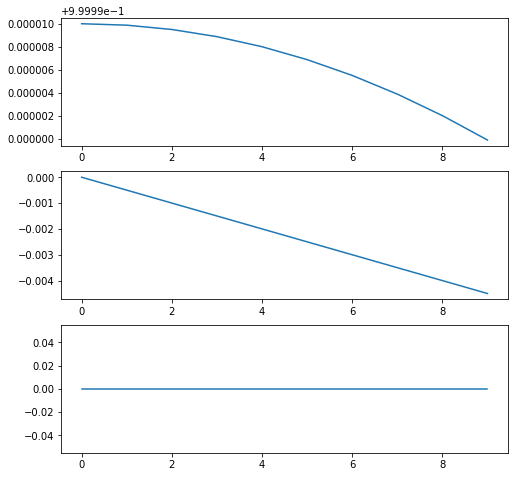

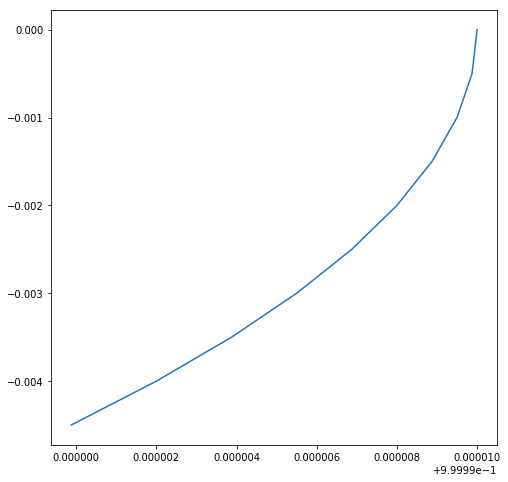

In [44]:
q0 = Quaternion(axis=[0,1,0], angle=0)
l = 1
k = 1
L = (l**2-1)/(l**2+1)
K = (k**2-1)/(k**2+1)
(ts, qs, n1s, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E, max_t=10e-3, return_n1s=True)
print(n1s)


fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2)
ax2 = fig.add_subplot(3, 1, 3)
ax0.plot(n1s[:,0])
ax1.plot(n1s[:,1])
ax2.plot(n1s[:,2])

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)
ax0.plot(n1s[:,0], n1s[:,1])


In [26]:
print(Quaternion(axis=(0, 1, 0), angle=np.pi*0).get_R())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# Case 1: Axisymmetric (1,1,7) vs slightly asymmetric (1,1.2,7)

Side-by-side comparison between two slightly different particles started in the same initial condition.

## A: initial condition in integrable region

See Fig 3.11 in Jonas' thesis for definitions of psi & theta.

These initial conditions are inside the integrable region, so the difference between symmetric and asymmetric particle is bounded.

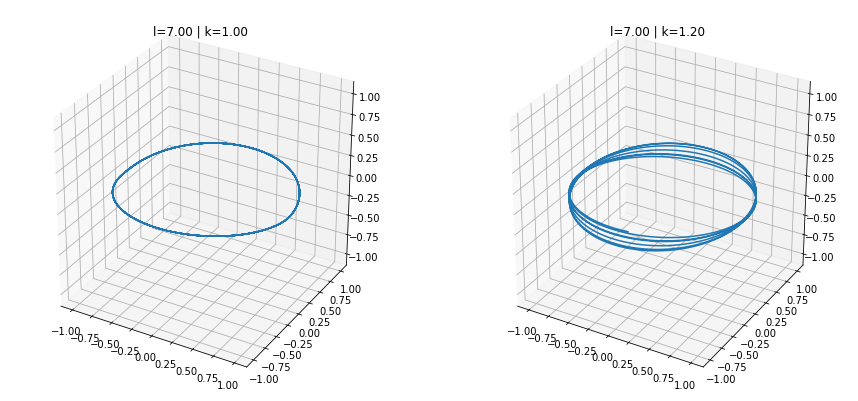

In [6]:
rot1=Quaternion(axis=[0,0,1], angle=0.1*np.pi/2) # this sets psi
rot2=Quaternion(axis=[1,0,0], angle=np.pi/2-0.1) # this sets theta
q0 = rot1.mul(rot2)
max_t = 300

fig = plt.figure(figsize=(15,8))

l = 7
k = 1
L = (l**2-1)/(l**2+1)
K = (k**2-1)/(k**2+1)

ax = fig.add_subplot(1,2,1, projection='3d')

(ts, qs, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E, max_t = max_t)
ax.plot(n3s[:,0],n3s[:,1],n3s[:,2],ls='solid', color='C0')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_zlim(-1.1,1.1)
ax.set_aspect('equal') 
ax.set_title('l={:.2f} | k={:.2f}'.format(l,k))

ax = fig.add_subplot(1,2,2, projection='3d')
l = 7
k = 1.2
L = (l**2-1)/(l**2+1)
K = (k**2-1)/(k**2+1)

(ts, qs, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E, max_t = max_t)
ax.plot(n3s[:,0],n3s[:,1],n3s[:,2],ls='solid', color='C0')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_zlim(-1.1,1.1)
ax.set_aspect('equal') 
ax.set_title('l={:.2f} | k={:.2f}'.format(l,k))
plt.show()

## B: initial condition in chaotic region

See Fig 3.11 in Jonas' thesis for definitions of psi & theta.

These initial conditions are inside the chaotic region, so the difference between symmetric and asymmetric particle is more pronounced.

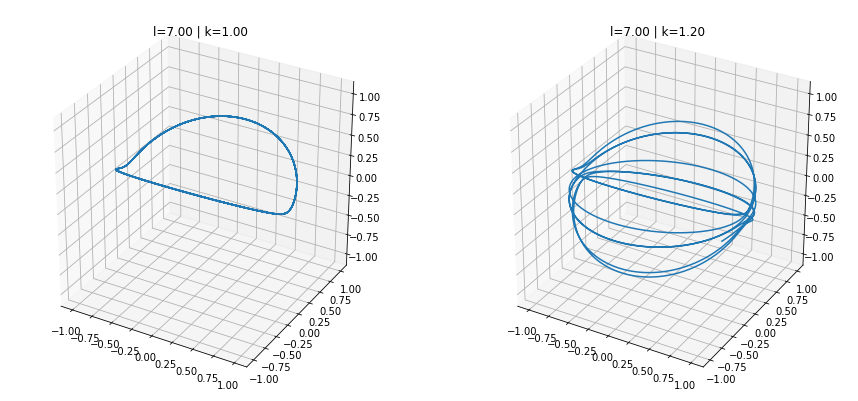

In [7]:
rot1=Quaternion(axis=[0,0,1], angle=0.95*np.pi/2) # this sets psi
rot2=Quaternion(axis=[1,0,0], angle=np.pi/2-0.1) # this sets theta
q0 = rot1.mul(rot2)
max_t = 300

fig = plt.figure(figsize=(15,8))

l = 7
k = 1
L = (l**2-1)/(l**2+1)
K = (k**2-1)/(k**2+1)

ax = fig.add_subplot(1,2,1, projection='3d')

(ts, qs, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E, max_t = max_t)
ax.plot(n3s[:,0],n3s[:,1],n3s[:,2],ls='solid', color='C0')
np.savetxt('symmetric-l7-k1.csv', np.hstack((ts,qs)), delimiter=',') # export!

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_zlim(-1.1,1.1)
ax.set_aspect('equal') 
ax.set_title('l={:.2f} | k={:.2f}'.format(l,k))

ax = fig.add_subplot(1,2,2, projection='3d')
l = 7
k = 1.2
L = (l**2-1)/(l**2+1)
K = (k**2-1)/(k**2+1)

(ts, qs, n2s, n3s) = jeffery_numerical(L, K, q0, Omega, E, max_t = max_t)
ax.plot(n3s[:,0],n3s[:,1],n3s[:,2],ls='solid', color='C0')
np.savetxt('asymmetric-l7-k1-2.csv', np.hstack((ts,qs)), delimiter=',') # export!

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_zlim(-1.1,1.1)
ax.set_aspect('equal') 
ax.set_title('l={:.2f} | k={:.2f}'.format(l,k))
plt.show()
